# Resnet 구현

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block_34(inputs, filters, strides=1, downsample=False):
    identity = inputs
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    if downsample:
        identity = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = Add()([x, identity])
    x = Activation('relu')(x)
    return x

def resnet_block_50(inputs, filters, strides=1, downsample=False):
    shortcut = inputs
    strides_temp = strides
    if downsample:
        if not filters == 64:
            strides_temp = 2
    
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)

    if downsample:
        shortcut = Conv2D(filters*4, (1, 1), strides=strides, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet_block(inputs, filters, strides=1, downsample=False, is_50=False):
    if is_50:
         x = resnet_block_50(inputs, filters, strides=strides, downsample=downsample)
    else:
         x = resnet_block_34(inputs, filters, strides=strides, downsample=downsample)
    return x

def build_resnet(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = resnet_block(x, filters, strides=strides, downsample=True, is_50=is_50)

        for _ in range(1, num_blocks):
            x = resnet_block(x, filters, is_50=is_50)

    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Resnet_50' if is_50 else 'Resnet_34'
    model = Model(inputs=inputs, outputs=x, name=name)

    model = Model(inputs=inputs, outputs=x)
    return model


In [2]:
#Build ResNet-34
input_shape = (32, 32, 3)
num_classes = 10

resnet_34 = build_resnet(input_shape, False, num_classes )
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [3]:
# Build ResNet-50
input_shape = (32, 32, 3)
num_classes = 10

resnet_50 = build_resnet(input_shape, True, num_classes )
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_53[0][0]     
____________________________________________________________________________________________

# 3) 일반 네트워크(plain network) 만들기

In [4]:
def plain_block_34(inputs, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block_50(inputs, filters, strides=1):
    strides_temp = 1
    if strides == 2:
        if not filters == 64:
            strides_temp = 2
    x = Conv2D(filters, (1, 1), strides=strides_temp, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters*4, (1, 1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def plain_block(inputs, filters, strides=1, is_50=False):
    if is_50:
         x = plain_block_50(inputs, filters, strides=strides)
    else:
         x = plain_block_34(inputs, filters, strides=strides)
    return x

def build_plain(input_shape=(224,224,3), is_50=False, num_classes=10, is_output=False):
    layer_spec = {
        18: ([2, 2, 2, 2], [64, 128, 256, 512]),
        34: ([3, 4, 6, 3], [64, 128, 256, 512]),
        50: ([3, 4, 6, 3], [64, 128, 256, 512]),
        101: ([3, 4, 23, 3], [256, 512, 1024, 2048])
    }

    num_layers = 50 if is_50 else 34
    layer_counts, num_filters = layer_spec[num_layers]
    if len(num_filters) != 4:
        raise ValueError("Number of filter counts should be 4.")

    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    filters = num_filters[0]
    for stage, (num_blocks, filters) in enumerate(zip(layer_counts, num_filters)):
        strides = 1 if stage == 0 else 2
        x = plain_block(x, filters, strides=strides, is_50=is_50)

        for _ in range(1, num_blocks):
            x = plain_block(x, filters, is_50=is_50)
    if is_output:
        x = AveragePooling2D(pool_size=(input_shape[0] // 32, input_shape[1] // 32))(x)
        x = Flatten()(x)
        if num_classes == 2:
            x = Dense(1, activation='sigmoid')(x)  
        else:
            x = Dense(num_classes, activation='softmax')(x)
    name = 'Plain_50' if is_50 else 'Plain_34'
    model = Model(inputs=inputs, outputs=x, name=name)
    return model


In [5]:
#Build Plain-34
input_shape = (224, 224, 3)
num_classes = 10

plain_34 = build_plain(input_shape, False, num_classes, True)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_106 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_107 (Bat (None, 56, 56, 64)        256

In [6]:
#Build Plain-50
input_shape = (224, 224, 3)
num_classes = 10

plain_50 = build_plain(input_shape, True, num_classes, False )
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_139 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_140 (Bat (None, 56, 56, 64)        256

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
import urllib3
import tensorflow_datasets as tfds
try:
    # Load the tf_flowers dataset
    dataset_name = 'cats_vs_dogs'
    train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

    # Preprocess the images and create batches
    batch_size = 32
    def preprocess_image(image, label):
        image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
        image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet-50
        return image, label

    train_dataset = train_dataset.map(preprocess_image)
    train_dataset = train_dataset.batch(batch_size)
    validation_dataset = validation_dataset.map(preprocess_image)
    validation_dataset = validation_dataset.batch(batch_size)
except:
    print('이미지 다운로드 실패')
    pass
input_shape = (224, 224, 3)
num_classes = 2

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

이미지 다운로드 실패


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# 데이터 경로 설정
train_dir = './data/PetImages/'

# 데이터 전처리 및 증강
image_size = (224, 224)  # 이미지 크기 설정
batch_size = 32

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 스케일 조정
)

# 훈련 데이터셋 생성
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # 이진 분류인 경우
    # class_mode='categorical'  # 다중 분류인 경우
)


# 훈련 데이터셋과 검증 데이터셋으로 분할
train_images, val_images, train_labels, val_labels = train_test_split(
    train_dataset[0][0],
    train_dataset[0][1],
    test_size=0.2,
    random_state=42
)

# 훈련 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(batch_size)

# 검증 데이터셋 생성
validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
validation_dataset = validation_dataset.batch(batch_size)

input_shape = (224, 224, 3)
num_classes = 2

Found 25000 images belonging to 2 classes.


In [10]:
resnet_34 = build_plain(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_resnet(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.7935 - accuracy: 0.2800 - val_loss: 0.6886 - val_accuracy: 0.7143
Epoch 2/10
1/1 [==============================] - 0s 175ms/step - loss: 3.4306 - accuracy: 0.3200 - val_loss: 0.6865 - val_accuracy: 0.7143
Epoch 3/10
1/1 [==============================] - 0s 174ms/step - loss: 0.7980 - accuracy: 0.3600 - val_loss: 0.7137 - val_accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - 0s 173ms/step - loss: 1.0495 - accuracy: 0.5200 - val_loss: 0.7663 - val_accuracy: 0.2857
Epoch 5/10
1/1 [==============================] - 0s 173ms/step - loss: 0.6806 - accuracy: 0.5600 - val_loss: 0.8097 - val_accuracy: 0.2857
Epoch 6/10
1/1 [==============================] - 0s 174ms/step - loss: 0.5996 - accuracy: 0.7200 - val_loss: 0.8595 - val_accuracy: 0.2857
Epoch 7/10
1/1 [==============================] - 0s 172ms/step - loss: 0.5985 - accuracy: 0.7200 - val_loss: 0.9137 - val_accuracy: 0.2857
Epoch 8/10
1/1 [=======

In [13]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.9467 - accuracy: 0.7200 - val_loss: 0.6535 - val_accuracy: 0.7143
Epoch 2/10
1/1 [==============================] - 0s 297ms/step - loss: 4.4844 - accuracy: 0.5200 - val_loss: 0.7367 - val_accuracy: 0.2857
Epoch 3/10
1/1 [==============================] - 0s 297ms/step - loss: 2.3714 - accuracy: 0.3600 - val_loss: 0.7250 - val_accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - 0s 295ms/step - loss: 0.8449 - accuracy: 0.5200 - val_loss: 0.7089 - val_accuracy: 0.2857
Epoch 5/10
1/1 [==============================] - 0s 295ms/step - loss: 1.5080 - accuracy: 0.5200 - val_loss: 0.7385 - val_accuracy: 0.2857
Epoch 6/10
1/1 [==============================] - 0s 298ms/step - loss: 0.8852 - accuracy: 0.7200 - val_loss: 0.7734 - val_accuracy: 0.2857
Epoch 7/10
1/1 [==============================] - 0s 298ms/step - loss: 0.4636 - accuracy: 0.8000 - val_loss: 0.7894 - val_accuracy: 0.2857
Epoch 8/10
1/1 [=======

In [14]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6204 - accuracy: 0.7200 - val_loss: 0.6892 - val_accuracy: 0.7143
Epoch 2/10
1/1 [==============================] - 0s 174ms/step - loss: 2.6352 - accuracy: 0.3600 - val_loss: 0.6853 - val_accuracy: 0.7143
Epoch 3/10
1/1 [==============================] - 0s 174ms/step - loss: 1.1243 - accuracy: 0.5200 - val_loss: 0.7031 - val_accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - 0s 176ms/step - loss: 1.0457 - accuracy: 0.2800 - val_loss: 0.6602 - val_accuracy: 0.7143
Epoch 5/10
1/1 [==============================] - 0s 175ms/step - loss: 0.7576 - accuracy: 0.3200 - val_loss: 0.6376 - val_accuracy: 0.7143
Epoch 6/10
1/1 [==============================] - 0s 174ms/step - loss: 0.7222 - accuracy: 0.3200 - val_loss: 4.0219 - val_accuracy: 0.7143
Epoch 7/10
1/1 [==============================] - 0s 172ms/step - loss: 0.6737 - accuracy: 0.3600 - val_loss: 16.0665 - val_accuracy: 0.7143
Epoch 8/10
1/1 [======

In [15]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.9177 - accuracy: 0.7200 - val_loss: 0.6627 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 308ms/step - loss: 1.9203 - accuracy: 0.5200 - val_loss: 0.8334 - val_accuracy: 0.2857
Epoch 3/10
1/1 [==============================] - 0s 309ms/step - loss: 4.5511 - accuracy: 0.6400 - val_loss: 0.7242 - val_accuracy: 0.2857
Epoch 4/10
1/1 [==============================] - 0s 335ms/step - loss: 0.4227 - accuracy: 0.8000 - val_loss: 0.6726 - val_accuracy: 0.5714
Epoch 5/10
1/1 [==============================] - 0s 297ms/step - loss: 1.6745 - accuracy: 0.3600 - val_loss: 0.7122 - val_accuracy: 0.2857
Epoch 6/10
1/1 [==============================] - 0s 300ms/step - loss: 0.5429 - accuracy: 0.7600 - val_loss: 0.7674 - val_accuracy: 0.2857
Epoch 7/10
1/1 [==============================] - 0s 300ms/step - loss: 0.1797 - accuracy: 0.9200 - val_loss: 0.9031 - val_accuracy: 0.2857
Epoch 8/10
1/1 [=======

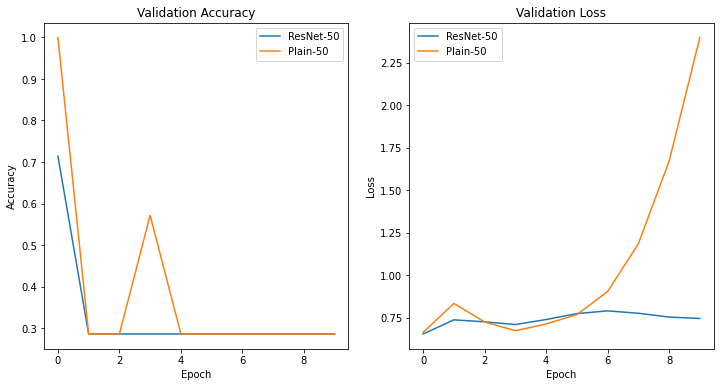

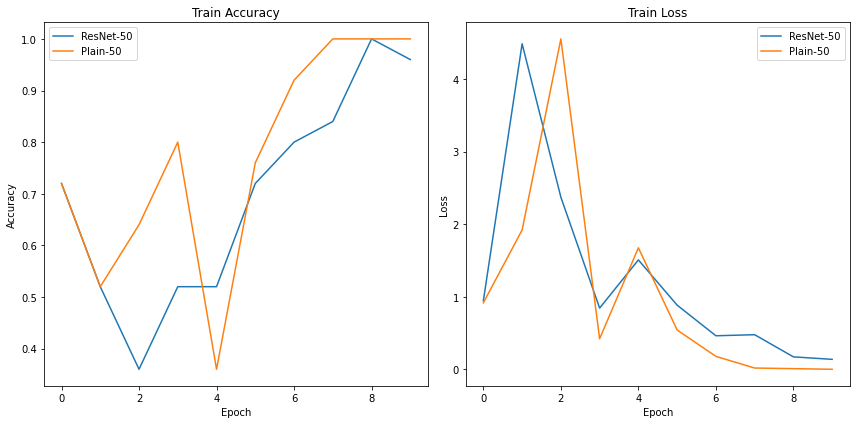

In [16]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

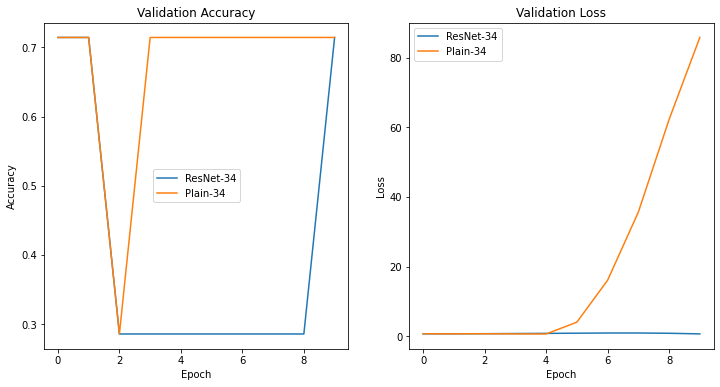

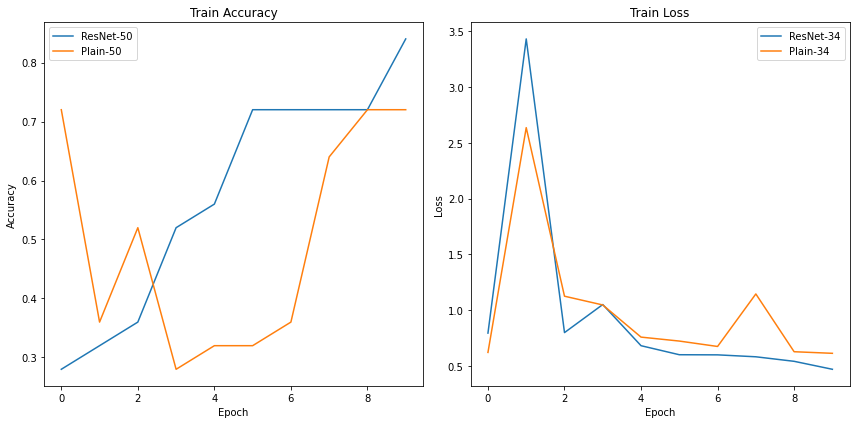

In [17]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

## tf_flowers datasets

In [18]:
import urllib3
import tensorflow_datasets as tfds

urllib3.disable_warnings()

# Load the tf_flowers dataset
dataset_name = 'tf_flowers'
train_dataset, validation_dataset = tfds.load(name=dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True)

# Preprocess the images and create batches
batch_size = 32
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
    image = tf.keras.applications.resnet.preprocess_input(image)  # Preprocess images for ResNet-50
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.map(preprocess_image)
validation_dataset = validation_dataset.batch(batch_size)
input_shape = (224, 224, 3)
num_classes = 5

In [19]:
resnet_34 = build_plain(input_shape, False, num_classes, True)
plain_34 = build_plain(input_shape, False, num_classes, True)
resnet_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plain_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
resnet_50 = build_resnet(input_shape, True, num_classes, True)
plain_50 = build_resnet(input_shape, True, num_classes, True)
plain_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
resnet_34_history = resnet_34.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 22s 206ms/step - loss: 1.5778 - accuracy: 0.3219 - val_loss: 535.5326 - val_accuracy: 0.2534
Epoch 2/10
92/92 [==============================] - 17s 182ms/step - loss: 1.3879 - accuracy: 0.3747 - val_loss: 7.1693 - val_accuracy: 0.2575
Epoch 3/10
92/92 [==============================] - 16s 179ms/step - loss: 1.3645 - accuracy: 0.3896 - val_loss: 1.7332 - val_accuracy: 0.3733
Epoch 4/10
92/92 [==============================] - 16s 179ms/step - loss: 1.3582 - accuracy: 0.3835 - val_loss: 1.5156 - val_accuracy: 0.4155
Epoch 5/10
92/92 [==============================] - 17s 180ms/step - loss: 1.2542 - accuracy: 0.4547 - val_loss: 1.8061 - val_accuracy: 0.4373
Epoch 6/10
92/92 [==============================] - 17s 182ms/step - loss: 1.2222 - accuracy: 0.4860 - val_loss: 3.5651 - val_accuracy: 0.4714
Epoch 7/10
92/92 [==============================] - 17s 182ms/step - loss: 1.1996 - accuracy: 0.5146 - val_loss: 1.2985 - val_accuracy: 0.43

In [22]:
resnet_50_history = resnet_50.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 41s 381ms/step - loss: 1.6391 - accuracy: 0.4506 - val_loss: 1.6389 - val_accuracy: 0.3351
Epoch 2/10
92/92 [==============================] - 32s 352ms/step - loss: 1.1866 - accuracy: 0.5525 - val_loss: 1.3718 - val_accuracy: 0.4823
Epoch 3/10
92/92 [==============================] - 32s 349ms/step - loss: 1.1298 - accuracy: 0.5879 - val_loss: 1.6490 - val_accuracy: 0.5245
Epoch 4/10
92/92 [==============================] - 32s 351ms/step - loss: 1.0681 - accuracy: 0.6172 - val_loss: 3.7078 - val_accuracy: 0.6199
Epoch 5/10
92/92 [==============================] - 32s 348ms/step - loss: 0.9967 - accuracy: 0.6369 - val_loss: 1.5775 - val_accuracy: 0.6022
Epoch 6/10
92/92 [==============================] - 32s 348ms/step - loss: 0.9136 - accuracy: 0.6618 - val_loss: 1.8930 - val_accuracy: 0.5559
Epoch 7/10
92/92 [==============================] - 32s 350ms/step - loss: 0.8579 - accuracy: 0.6856 - val_loss: 1.4842 - val_accuracy: 0.5981

In [23]:
plain_34_history = plain_34.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 20s 185ms/step - loss: 1.7329 - accuracy: 0.2255 - val_loss: 54.1753 - val_accuracy: 0.1785
Epoch 2/10
92/92 [==============================] - 17s 185ms/step - loss: 1.6139 - accuracy: 0.2466 - val_loss: 3.4899 - val_accuracy: 0.2480
Epoch 3/10
92/92 [==============================] - 17s 183ms/step - loss: 1.6202 - accuracy: 0.2473 - val_loss: 1.7226 - val_accuracy: 0.1730
Epoch 4/10
92/92 [==============================] - 17s 180ms/step - loss: 1.6095 - accuracy: 0.2415 - val_loss: 1.8594 - val_accuracy: 0.1880
Epoch 5/10
92/92 [==============================] - 16s 179ms/step - loss: 1.5480 - accuracy: 0.2871 - val_loss: 1.6711 - val_accuracy: 0.2738
Epoch 6/10
92/92 [==============================] - 17s 180ms/step - loss: 1.5244 - accuracy: 0.3031 - val_loss: 32.3862 - val_accuracy: 0.3079
Epoch 7/10
92/92 [==============================] - 17s 181ms/step - loss: 1.4276 - accuracy: 0.3549 - val_loss: 1.5009 - val_accuracy: 0.32

In [24]:
plain_50_history = plain_50.fit(train_dataset, validation_data=validation_dataset, epochs=10)

Epoch 1/10
92/92 [==============================] - 38s 360ms/step - loss: 1.6518 - accuracy: 0.4530 - val_loss: 1.5256 - val_accuracy: 0.3910
Epoch 2/10
92/92 [==============================] - 32s 350ms/step - loss: 1.2141 - accuracy: 0.5429 - val_loss: 1.7681 - val_accuracy: 0.3992
Epoch 3/10
92/92 [==============================] - 32s 347ms/step - loss: 1.1574 - accuracy: 0.5698 - val_loss: 16.0564 - val_accuracy: 0.4196
Epoch 4/10
92/92 [==============================] - 32s 350ms/step - loss: 1.0280 - accuracy: 0.6175 - val_loss: 1.5243 - val_accuracy: 0.5981
Epoch 5/10
92/92 [==============================] - 32s 349ms/step - loss: 0.9941 - accuracy: 0.6400 - val_loss: 13.1345 - val_accuracy: 0.3992
Epoch 6/10
92/92 [==============================] - 32s 349ms/step - loss: 1.2129 - accuracy: 0.5630 - val_loss: 21.7852 - val_accuracy: 0.2534
Epoch 7/10
92/92 [==============================] - 32s 350ms/step - loss: 0.9940 - accuracy: 0.6376 - val_loss: 0.9388 - val_accuracy: 0.6

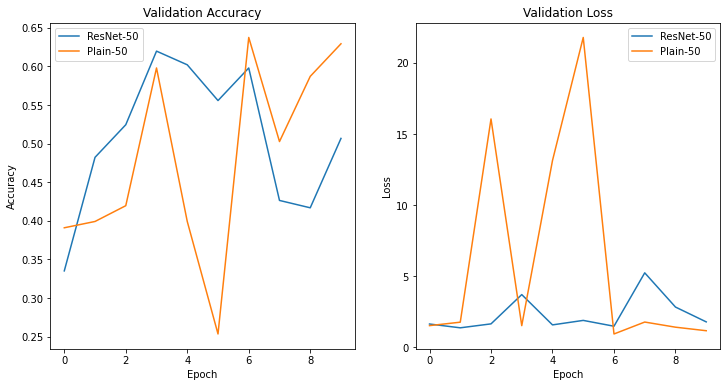

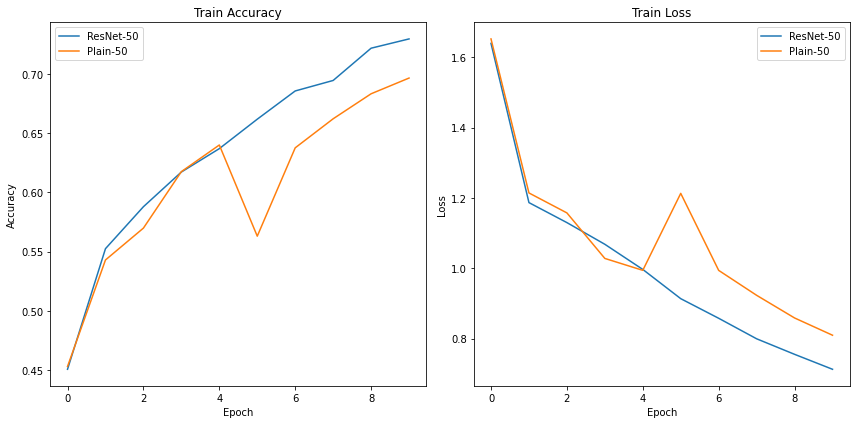

In [25]:
import matplotlib.pyplot as plt
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_50_history.history['val_accuracy'], label='ResNet-50')
ax1.plot(plain_50_history.history['val_accuracy'], label='Plain-50')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_50_history.history['val_loss'], label='ResNet-50')
ax2.plot(plain_50_history.history['val_loss'], label='Plain-50')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_50_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_50_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_50_history.history['loss'], label='ResNet-50')
ax4.plot(plain_50_history.history['loss'], label='Plain-50')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

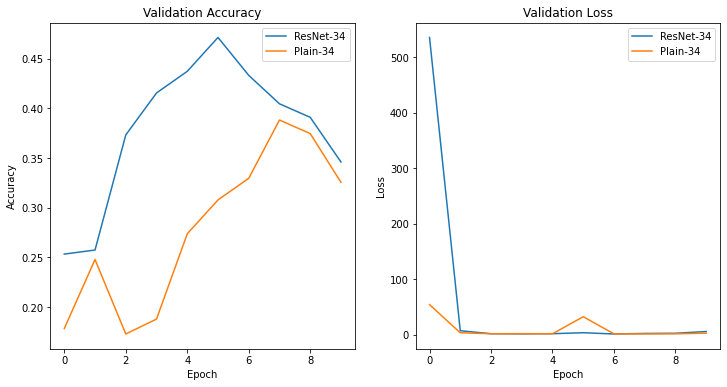

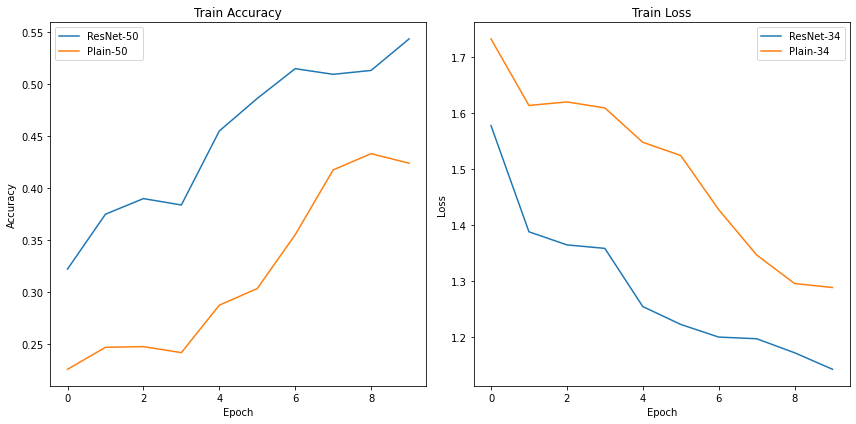

In [26]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot validation accuracy
ax1.plot(resnet_34_history.history['val_accuracy'], label='ResNet-34')
ax1.plot(plain_34_history.history['val_accuracy'], label='Plain-34')
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot validation loss
ax2.plot(resnet_34_history.history['val_loss'], label='ResNet-34')
ax2.plot(plain_34_history.history['val_loss'], label='Plain-34')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()


# Create subplots for train loss and train accuracy
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))

# Plot train accuracy
ax3.plot(resnet_34_history.history['accuracy'], label='ResNet-50')
ax3.plot(plain_34_history.history['accuracy'], label='Plain-50')
ax3.set_title('Train Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

# Plot train loss
ax4.plot(resnet_34_history.history['loss'], label='ResNet-34')
ax4.plot(plain_34_history.history['loss'], label='Plain-34')
ax4.set_title('Train Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()